# Bayesian Optimisation Capstone: Complete Intelligent Workflow

**Course note pointer:** This workflow follows the capstone guidance for how to run the weekly optimisation loop and what to show in the final repository (Module 12 Mini-lesson 12.7 and the Capstone FAQs).

This notebook is my working template for the Bayesian black-box optimisation capstone. The aim is simple: for each of the eight black-box functions, I propose one new input point per week, submit those points in the portal, then fold the returned outputs back into my dataset and repeat.

## What this notebook does:

- ✅ **Intelligent state detection** - skips initial setup if already done
- ✅ **Asks for week number** - processes Week N → generates Week N+1
- ✅ **Auto-loads portal downloads** - handles all formats automatically
- ✅ **Fits Gaussian Process surrogate models** per function
- ✅ **Uses acquisition functions** (EI/UCB/PI/MaxVar) to propose next points
- ✅ **Produces portal-ready strings** (hyphen-separated, six decimals, no spaces)
- ✅ **Displays inputs, results, and plots inline** for review
- ✅ **Creates timestamped backups** before every change
- ✅ **Maintains execution logs** for complete audit trail

## Folder structure:

```
CapStone00/
├── initial_data/              # From Initial_data_points_starter.zip
│   ├── function_1/ ... function_8/
│   │   ├── initial_inputs.npy
│   │   ├── initial_outputs.npy
│   │   └── backups/           # Auto-created timestamped backups
├── submissions/               # Portal downloads organised by week
│   ├── week_01/
│   │   ├── Week01-*.txt       # Portal confirmation
│   │   └── outputs.txt        # Portal results
│   ├── week_02/ ...
├── plots/                     # Progress visualisations
│   ├── current/
│   └── historical/
├── logs/                      # Execution logs (JSON)
└── notebooks/                 # This notebook
```

**Course references:**
- Module 12 Mini-lesson 12.7: *A deeper look into the capstone*
- Module 12 Mini-lesson 12.8: *Data and descriptions of functions for Bayesian optimisation competition*
- Module 12 Capstone Project FAQs

---

## Weekly loop (what I actually do)

**Course note pointer:** This is the weekly cadence described in the capstone guidance (Module 12 Mini-lesson 12.7 and the FAQs).

I have eight synthetic black-box functions. Each week I run the same loop:

1. Review the data I already have for each function (initially the starter `.npy` files, later the accumulated points).
2. Choose one new input point `x` per function using Bayesian Optimisation.
3. Submit each `x` in the portal using the exact numeric string format.
4. Receive the output `y` for each submitted `x`.
5. Append `(x, y)` to the dataset and repeat next week.

I also keep a short note each week covering:
- what method I used (and why),
- whether my query was more exploration or exploitation,
- what the latest result taught me,
- how I plan to adjust next week.

**Course references:**
- Module 12 Mini-lesson 12.7: *A deeper look into the capstone*
- Capstone Project FAQs

## Cell 1: Configuration and Setup

**Course note pointer:** The required folder structure and starter files come from the capstone pack described in the FAQs and the Module 12 capstone notes.

In [1]:
"""
Configuration and Imports

Course note mapping (Module 12):
- Surrogate model (Gaussian Process regression): Mini-lesson 12.1
- Acquisition functions (EI/UCB/PI/max-variance): Mini-lesson 12.6
- Maximisation framing (treating objective as maximise y): Mini-lesson 12.3
"""

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
import json
import shutil
import warnings
import re

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel as C
from scipy.stats import norm

warnings.filterwarnings('ignore')

# ============================================================================
# PROJECT PATHS (Auto-detect CapStone00 structure)
# ============================================================================

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_ROOT = PROJECT_ROOT / 'initial_data'
SUBMISSIONS_DIR = PROJECT_ROOT / 'submissions'
PLOTS_DIR = PROJECT_ROOT / 'plots'
LOGS_DIR = PROJECT_ROOT / 'logs'

# ============================================================================
# CONSTANTS (Course Reference: Module 12 FAQ - Initial data sizes)
# ============================================================================

# Initial dataset sizes per function
INITIAL_SIZES = {
    1: (10, 2),   # Function 1: 10 data points, 2D
    2: (10, 2),   # Function 2: 10 data points, 2D
    3: (15, 3),   # Function 3: 15 data points, 3D
    4: (30, 4),   # Function 4: 30 data points, 4D
    5: (20, 4),   # Function 5: 20 data points, 4D
    6: (20, 5),   # Function 6: 20 data points, 5D
    7: (30, 6),   # Function 7: 30 data points, 6D
    8: (40, 8),   # Function 8: 40 data points, 8D
}

# Function descriptions (Course Reference: Mini-lesson 12.8)
FUNCTION_DESCRIPTIONS = {
    1: "2D source localisation (contamination/radiation detection)",
    2: "2D noisy scoring system with local optima",
    3: "3D drug discovery mixture optimisation",
    4: "4D business configuration with costly evaluations",
    5: "4D chemical process yield maximisation",
    6: "5D recipe-style optimisation",
    7: "6D hyperparameter tuning",
    8: "8D high-dimensional hyperparameter optimisation"
}

# ============================================================================
# BAYESIAN OPTIMISATION PARAMETERS
# ============================================================================

# Reproducibility
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)

# Candidate sampling budget for approximating the acquisition argmax
N_CANDIDATES = 200_000

# Acquisition function parameters
EI_XI = 0.01      # exploration margin for Expected Improvement and Probability of Improvement
UCB_KAPPA = 2.0   # explore/exploit balance for Upper Confidence Bound

print("="*70)
print("BAYESIAN OPTIMISATION CAPSTONE - INTELLIGENT WORKFLOW")
print("="*70)
print(f"Project Root: {PROJECT_ROOT}")
print(f"Data Root: {DATA_ROOT}")
print(f"Data exists: {DATA_ROOT.exists()}")
print(f"Submissions: {SUBMISSIONS_DIR.exists()}")
print(f"\nBayesian Optimisation Settings:")
print(f"  Random Seed: {RNG_SEED}")
print(f"  Candidates per optimisation: {N_CANDIDATES:,}")
print(f"  EI exploration margin (ξ): {EI_XI}")
print(f"  UCB exploration factor (κ): {UCB_KAPPA}")
print("="*70)
print("✓ Configuration loaded")

BAYESIAN OPTIMISATION CAPSTONE - INTELLIGENT WORKFLOW
Project Root: c:\Users\Diran\Coursework\CapStone00
Data Root: c:\Users\Diran\Coursework\CapStone00\initial_data
Data exists: True
Submissions: True

Bayesian Optimisation Settings:
  Random Seed: 42
  Candidates per optimisation: 200,000
  EI exploration margin (ξ): 0.01
  UCB exploration factor (κ): 2.0
✓ Configuration loaded


## Cell 2: Directory Management

**Course note pointer:** Repository organisation requirements from Module 12 Mini-lesson 12.7

In [2]:
"""
Directory Structure Validation
"""

def ensure_directories():
    """Create missing directories in CapStone00 structure"""
    required_dirs = [
        SUBMISSIONS_DIR,
        PLOTS_DIR,
        PLOTS_DIR / 'current',
        PLOTS_DIR / 'historical',
        LOGS_DIR,
    ]
    
    created = []
    for dir_path in required_dirs:
        if not dir_path.exists():
            dir_path.mkdir(parents=True, exist_ok=True)
            created.append(dir_path.relative_to(PROJECT_ROOT))
    
    if created:
        print(f"✓ Created: {', '.join(str(d) for d in created)}")
    else:
        print("✓ All directories exist")
    
    # Create backup directories for each function
    if DATA_ROOT.exists():
        for k in range(1, 9):
            backup_dir = DATA_ROOT / f"function_{k}" / "backups"
            backup_dir.mkdir(exist_ok=True)

def validate_initial_data():
    """Validate initial data structure (Course Reference: FAQ - Initial data)"""
    if not DATA_ROOT.exists():
        print("❌ initial_data/ not found!")
        print("\nPlease extract Initial_data_points_starter.zip to:")
        print(f"  {PROJECT_ROOT}/")
        return False
    
    print("\nValidating initial data:")
    missing = []
    for k in range(1, 9):
        fdir = DATA_ROOT / f"function_{k}"
        inputs_file = fdir / "initial_inputs.npy"
        outputs_file = fdir / "initial_outputs.npy"
        
        if not inputs_file.exists() or not outputs_file.exists():
            missing.append(k)
        else:
            # Verify shape
            X = np.load(inputs_file)
            y = np.load(outputs_file)
            expected_shape = INITIAL_SIZES[k]
            status = "✓" if X.shape == expected_shape and len(y) == expected_shape[0] else "⚠"
            print(f"  {status} Function {k}: X{X.shape}, y{y.shape}")
    
    if missing:
        print(f"\n❌ Missing data for functions: {missing}")
        return False
    
    print("\n✓ All initial data validated")
    return True

# Run validation
ensure_directories()
validate_initial_data()

✓ All directories exist

Validating initial data:
  ✓ Function 1: X(10, 2), y(10,)
  ✓ Function 2: X(10, 2), y(10,)
  ✓ Function 3: X(15, 3), y(15,)
  ✓ Function 4: X(30, 4), y(30,)
  ✓ Function 5: X(20, 4), y(20,)
  ✓ Function 6: X(20, 5), y(20,)
  ✓ Function 7: X(30, 6), y(30,)
  ✓ Function 8: X(40, 8), y(40,)

✓ All initial data validated


True

## Cell 3: Core BBO Functions - Portal Format Utilities

**Course note pointer:** Strict portal format from Module 12 FAQ - "What do I submit?"

In [3]:
"""
Portal Format Utilities

Course Reference: Module 12 FAQ - Submission format requirements
- Format: x1-x2-x3-...-xn
- Exactly 6 decimals per value
- Hyphen-separated, no spaces
- Values in range [0.000000, 0.999999]
"""

def clamp01(x: np.ndarray) -> np.ndarray:
    """
    Clamp to valid capstone input range: [0.000000, 0.999999]
    
    Course Reference: FAQ - Input constraints
    """
    x = np.asarray(x, dtype=float)
    return np.clip(x, 0.0, 0.999999)

def portal_string(x: np.ndarray) -> str:
    """
    Format array to portal submission string: '0.123456-0.654321-...'
    
    Course Reference: FAQ - Exact formatting requirements
    """
    x = clamp01(x)
    return "-".join(f"{v:.6f}" for v in x)

def parse_portal_string(s: str, d: int) -> np.ndarray:
    """
    Parse portal string back to array
    """
    parts = s.strip().split("-")
    if len(parts) != d:
        raise ValueError(f"Expected {d} values, got {len(parts)}: {s!r}")
    return clamp01(np.array([float(p) for p in parts], dtype=float))

def validate_portal_string(s: str, d: int) -> bool:
    """
    Strict portal pattern validation: 0.xxxxxx with exactly six decimals
    
    Course Reference: FAQ - Common errors to avoid
    """
    pattern = r"^0\.\d{6}" + (r"-(0\.\d{6})" * (d - 1)) + r"$"
    return re.match(pattern, s.strip()) is not None

# Test the utilities
test_x = np.array([0.123456, 0.654321])
test_str = portal_string(test_x)
print(f"Example portal string: {test_str}")
print(f"Valid format: {validate_portal_string(test_str, 2)}")
print("✓ Portal format utilities loaded")

Example portal string: 0.123456-0.654321
Valid format: True
✓ Portal format utilities loaded


## Cell 4: Gaussian Process Surrogate Model

**Course note mapping (Module 12):**
- Surrogate model: Mini-lesson 12.1 - Gaussian Process Regression
- Kernel selection: Mini-lesson 12.2 - Matérn kernel for smoothness
- Hyperparameter optimisation: Mini-lesson 12.4 - Marginal likelihood

In [4]:
"""
Gaussian Process Surrogate Model

Course Reference: Module 12 FAQ - "What optimisation method should I use?"
Recommended: Gaussian Process for expensive black-box functions
"""

def fit_gp_surrogate(X: np.ndarray, y: np.ndarray, random_state: int = 0):
    """
    Fit GP surrogate model with standardised outputs
    
    Course Reference: Mini-lesson 12.1 - GP Regression basics
    
    Returns:
        gp: Fitted GaussianProcessRegressor
        y_mean: Mean used for standardisation
        y_std: Std used for standardisation
    """
    # Standardise y for numerical stability
    y = np.asarray(y, dtype=float).ravel()
    y_mean = float(y.mean())
    y_std = float(y.std()) if float(y.std()) > 0 else 1.0
    y_scaled = (y - y_mean) / y_std

    d = X.shape[1]
    
    # Kernel: Constant * Matérn + WhiteKernel for noise
    # Course Reference: Mini-lesson 12.2 - Matérn kernel (nu=2.5 for twice-differentiable functions)
    kernel = (
        C(1.0, (1e-3, 1e3))
        * Matern(length_scale=np.ones(d), length_scale_bounds=(1e-3, 1e2), nu=2.5)
        + WhiteKernel(noise_level=1e-6, noise_level_bounds=(1e-10, 1e-1))
    )

    # Fit GP with multiple random restarts for robust hyperparameter optimisation
    # Course Reference: Mini-lesson 12.4 - Marginal likelihood optimisation
    gp = GaussianProcessRegressor(
        kernel=kernel,
        n_restarts_optimizer=8,
        random_state=random_state,
    )
    gp.fit(X, y_scaled)
    
    return gp, y_mean, y_std

print("✓ Gaussian Process surrogate model loaded")
print("  Kernel: Constant × Matérn(ν=2.5) + WhiteKernel")
print("  Hyperparameter optimisation: 8 random restarts")

✓ Gaussian Process surrogate model loaded
  Kernel: Constant × Matérn(ν=2.5) + WhiteKernel
  Hyperparameter optimisation: 8 random restarts


## Cell 5: Acquisition Functions

**Course note mapping (Module 12):**
- Acquisition functions: Mini-lesson 12.6 - Trading off exploration and exploitation
- Expected Improvement: Mini-lesson 12.6 - Balance between mean and uncertainty
- Upper Confidence Bound: Mini-lesson 12.6 - Optimism in the face of uncertainty
- Probability of Improvement: Alternative acquisition strategy

In [5]:
"""
Acquisition Functions for Bayesian Optimisation

Course Reference: Module 12 Mini-lesson 12.6 - Acquisition functions guide the search
"""

def acquisition_ei(Xcand: np.ndarray, gp: GaussianProcessRegressor, y_best: float, xi: float = EI_XI) -> np.ndarray:
    """
    Expected Improvement for maximisation
    
    Course Reference: Mini-lesson 12.6 - EI balances exploration (σ) and exploitation (μ)
    
    Args:
        Xcand: Candidate points
        gp: Fitted GP model
        y_best: Best observed value (scaled)
        xi: Exploration parameter (default: 0.01)
    """
    mu, sigma = gp.predict(Xcand, return_std=True)
    sigma = np.maximum(sigma, 1e-12)  # Numerical stability
    
    improvement = mu - y_best - xi
    Z = improvement / sigma
    
    # EI = E[max(0, improvement)] = improvement*Φ(Z) + σ*φ(Z)
    return improvement * norm.cdf(Z) + sigma * norm.pdf(Z)

def acquisition_ucb(Xcand: np.ndarray, gp: GaussianProcessRegressor, kappa: float = UCB_KAPPA) -> np.ndarray:
    """
    Upper Confidence Bound for maximisation
    
    Course Reference: Mini-lesson 12.6 - UCB = μ + κσ (optimism under uncertainty)
    
    Args:
        Xcand: Candidate points
        gp: Fitted GP model
        kappa: Exploration factor (default: 2.0)
    """
    mu, sigma = gp.predict(Xcand, return_std=True)
    return mu + kappa * sigma

def acquisition_pi(Xcand: np.ndarray, gp: GaussianProcessRegressor, y_best: float, xi: float = EI_XI) -> np.ndarray:
    """
    Probability of Improvement for maximisation
    
    Course Reference: Mini-lesson 12.6 - PI = P(f(x) > y_best + ξ)
    """
    mu, sigma = gp.predict(Xcand, return_std=True)
    sigma = np.maximum(sigma, 1e-12)
    Z = (mu - y_best - xi) / sigma
    return norm.cdf(Z)

def acquisition_maxvar(Xcand: np.ndarray, gp: GaussianProcessRegressor) -> np.ndarray:
    """
    Maximum Variance (pure exploration)
    
    Course Reference: Mini-lesson 12.6 - Explore where uncertainty is highest
    """
    _, sigma = gp.predict(Xcand, return_std=True)
    return sigma

print("✓ Acquisition functions loaded:")
print("  - Expected Improvement (EI) - default, balanced")
print("  - Upper Confidence Bound (UCB) - more exploratory")
print("  - Probability of Improvement (PI) - more exploitative")
print("  - Maximum Variance (MaxVar) - pure exploration")

✓ Acquisition functions loaded:
  - Expected Improvement (EI) - default, balanced
  - Upper Confidence Bound (UCB) - more exploratory
  - Probability of Improvement (PI) - more exploitative
  - Maximum Variance (MaxVar) - pure exploration


## Cell 6: Proposal Generation

**Course note mapping (Module 12):**
- Iteratively select new points: FAQ - "Implement Bayesian optimisation"
- Acquisition function optimisation: Mini-lesson 12.6
- Avoiding duplicates: Best practice for robustness

In [6]:
"""
Next Point Proposal via Bayesian Optimisation

Course Reference: Module 12 FAQ - "Iteratively select new points using acquisition function"
"""

def propose_next_point(
    X: np.ndarray,
    y: np.ndarray,
    acquisition: str = "ei",
    n_candidates: int = N_CANDIDATES,
    rng: np.random.Generator = rng,
):
    """
    Propose next evaluation point using Bayesian Optimisation
    
    Course Reference: Module 12 FAQ - Complete BO workflow
    
    Args:
        X: Current input observations
        y: Current output observations
        acquisition: Acquisition function ('ei', 'ucb', 'pi', 'maxvar')
        n_candidates: Number of random candidates to sample
        rng: Random number generator
    
    Returns:
        x_next: Proposed next point
        diagnostics: Dictionary with optimisation details
    """
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float).ravel()
    d = X.shape[1]

    # Fit GP surrogate (Course Reference: Mini-lesson 12.1)
    try:
        gp, y_mean, y_std = fit_gp_surrogate(X, y, random_state=0)
    except Exception as e:
        # Defensive fallback: if GP fitting fails, return a random valid point
        x_fallback = clamp01(rng.random(d))
        return x_fallback, {"status": "fallback_random", "error": str(e)}

    # Generate random candidates in [0,1]^d
    Xcand = rng.random((int(n_candidates), d))

    # Best-so-far in scaled space (consistent with gp.predict output)
    y_scaled = (y - y_mean) / y_std
    y_best = float(y_scaled.max())

    # Evaluate acquisition function (Course Reference: Mini-lesson 12.6)
    acquisition = acquisition.lower().strip()
    if acquisition == "ei":
        scores = acquisition_ei(Xcand, gp, y_best=y_best, xi=EI_XI)
    elif acquisition == "ucb":
        scores = acquisition_ucb(Xcand, gp, kappa=UCB_KAPPA)
    elif acquisition == "pi":
        scores = acquisition_pi(Xcand, gp, y_best=y_best, xi=EI_XI)
    elif acquisition in {"maxvar", "var", "variance"}:
        scores = acquisition_maxvar(Xcand, gp)
    else:
        raise ValueError("acquisition must be one of: 'ei', 'ucb', 'pi', 'maxvar'")

    # Select best candidate
    idx = int(np.argmax(scores))
    x_next = clamp01(Xcand[idx])

    # Avoid exact duplicates (add tiny noise if needed)
    if np.any(np.all(np.isclose(X, x_next, atol=1e-12), axis=1)):
        x_next = clamp01(x_next + rng.normal(0, 1e-4, size=d))

    diagnostics = {
        "status": "ok",
        "acquisition": acquisition,
        "best_score": float(scores[idx]),
        "y_best_scaled": y_best,
        "y_best_original": float(y.max()),
        "n_candidates": int(n_candidates),
        "kernel": str(gp.kernel_),
    }
    
    return x_next, diagnostics

print("✓ Bayesian Optimisation proposal generator loaded")
print(f"  Sampling {N_CANDIDATES:,} candidates per optimisation")

✓ Bayesian Optimisation proposal generator loaded
  Sampling 200,000 candidates per optimisation


## Cell 7: Multi-Format Parser

**Course note pointer:** Portal provides multiple formats - this parser handles them all automatically

In [7]:
"""
Multi-Format Portal File Parser

Handles: Portal confirmation, Numpy arrays, Email format, Clean format
"""

def parse_portal_confirmation(filepath):
    """Parse Week01-*.txt format"""
    with open(filepath, 'r') as f:
        content = f.read()
    
    inputs = []
    for line in content.split('\n'):
        line = line.strip()
        if '-' in line and not line.startswith('Function') and not line.startswith('Submission'):
            if line and line[0].isdigit():
                inputs.append(line)
    return inputs if len(inputs) == 8 else None

def parse_numpy_format(filepath):
    """Parse numpy array format"""
    with open(filepath, 'r') as f:
        content = f.read().strip()
    if content.startswith('[') and 'array' in content:
        try:
            arrays = eval(content, {"array": np.array, "np": np})
            return arrays
        except:
            return None
    return None

def arrays_to_portal_format(arrays):
    """Convert arrays to portal strings"""
    return [portal_string(arr) for arr in arrays]

def load_week_inputs(week_num):
    """Load inputs for a week - try all formats"""
    week_dir = SUBMISSIONS_DIR / f"week_{week_num:02d}"
    if not week_dir.exists():
        return None, f"Week {week_num} directory not found"
    
    # Try portal confirmation first
    for conf_file in week_dir.glob("Week*.txt"):
        inputs = parse_portal_confirmation(conf_file)
        if inputs:
            return inputs, f"Portal confirmation: {conf_file.name}"
    
    # Try inputs.txt
    inputs_file = week_dir / "inputs.txt"
    if inputs_file.exists():
        # Try numpy format
        arrays = parse_numpy_format(inputs_file)
        if arrays:
            return arrays_to_portal_format(arrays), "Numpy format"
        # Try clean format
        with open(inputs_file, 'r') as f:
            lines = [line.strip() for line in f if line.strip() and not line.startswith('#')]
        if len(lines) == 8:
            return lines, "Clean format"
    
    return None, "No valid input file found"

def load_week_outputs(week_num):
    """
    Load outputs for a week with enhanced flexible parsing.
    Handles: Clean numbers, Numpy arrays, and np.float64() lists.
    """
    week_dir = SUBMISSIONS_DIR / f"week_{week_num:02d}"
    outputs_file = week_dir / "outputs.txt"
    
    if not outputs_file.exists():
        return None, f"outputs.txt not found in {week_dir.name}"
    
    with open(outputs_file, 'r') as f:
        content = f.read().strip()
    
    # --- Strategy 1: Flexible Regex Parser (Handles np.float64, lists, etc.) ---
    # This finds all numeric patterns, including scientific notation
    import re
    numeric_pattern = r"[-+]?\d*\.\d+(?:[eE][-+]?\d+)?|[-+]?\d+"
    found_numbers = re.findall(numeric_pattern, content)
    
    # Filter out numbers that might be part of 'float64' or 'week_01'
    # We only want the actual decimal values
    clean_outputs = []
    for val in found_numbers:
        # Ignore '64' if it follows 'float'
        if val == "64" and "float64" in content:
            continue
        try:
            clean_outputs.append(float(val))
        except ValueError:
            continue

    if len(clean_outputs) == 8:
        return clean_outputs, "Flexible/Regex format"
    
    # --- Strategy 2: Fallback to original Clean format ---
    outputs = []
    for line in content.split('\n'):
        line = line.strip()
        if line and not line.startswith('#'):
            try:
                outputs.append(float(line))
            except:
                continue
    
    if len(outputs) == 8:
        return outputs, "Clean line format"
    
    return None, f"Found {len(clean_outputs)} values, but need exactly 8. Check your outputs.txt"
    
    return None, "No valid output format found"

print("✓ Multi-format parser loaded (portal/numpy/clean)")

✓ Multi-format parser loaded (portal/numpy/clean)


## Cell 8: Data Management with Backups

**Course note mapping (Module 12):**
- Appending data: FAQ - Example code for appending new data points
- Data continuity: FAQ - "Keep track of all previously collected data points"

In [8]:
"""
Data Management with Automatic Backups

Course Reference: Module 12 FAQ - Appending new data points workflow
"""

def get_current_data_state():
    """Get current state of all datasets"""
    state = {}
    for k in range(1, 9):
        y = np.load(DATA_ROOT / f"function_{k}" / "initial_outputs.npy")
        initial_size = INITIAL_SIZES[k][0]
        state[k] = {
            'total_points': len(y),
            'initial_size': initial_size,
            'weeks_added': len(y) - initial_size,
            'best_value': float(y.max()),
            'latest_value': float(y[-1]) if len(y) > initial_size else None
        }
    return state

def backup_function_data(k, week_num):
    """Create timestamped backup"""
    fdir = DATA_ROOT / f"function_{k}"
    backup_dir = fdir / "backups"
    backup_dir.mkdir(exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    X = np.load(fdir / "initial_inputs.npy")
    y = np.load(fdir / "initial_outputs.npy")
    
    np.save(backup_dir / f"inputs_before_week{week_num:02d}_{timestamp}.npy", X)
    np.save(backup_dir / f"outputs_before_week{week_num:02d}_{timestamp}.npy", y)
    return backup_dir

def append_week_data(week_inputs, week_outputs, week_num):
    """
    Append weekly results to all function datasets
    
    Course Reference: Module 12 FAQ - Example code pattern
    """
    print(f"\n{'='*70}")
    print(f"APPENDING WEEK {week_num} DATA")
    print(f"{'='*70}")
    
    summary = {}
    
    for k in range(1, 9):
        fdir = DATA_ROOT / f"function_{k}"
        
        # Load current data
        X = np.load(fdir / "initial_inputs.npy")
        y = np.load(fdir / "initial_outputs.npy")
        
        # Parse new point
        x_new = parse_portal_string(week_inputs[k-1], d=X.shape[1])
        y_new = week_outputs[k-1]
        
        # Validate
        if len(x_new) != X.shape[1]:
            raise ValueError(f"Function {k}: Expected {X.shape[1]}D, got {len(x_new)}D")
        
        # Backup
        backup_function_data(k, week_num)
        
        # Append (Course Reference: FAQ pattern - vstack and append)
        X_updated = np.vstack((X, x_new))
        y_updated = np.append(y, y_new)
        
        # Save
        np.save(fdir / "initial_inputs.npy", X_updated)
        np.save(fdir / "initial_outputs.npy", y_updated)
        
        # Summary
        old_best = y.max()
        new_best = y_updated.max()
        improved = y_new > old_best
        
        summary[k] = {
            'old_size': len(y),
            'new_size': len(y_updated),
            'new_value': y_new,
            'old_best': old_best,
            'new_best': new_best,
            'improved': improved,
            'description': FUNCTION_DESCRIPTIONS[k]
        }
        
        status = "📈 NEW BEST" if improved else "📊"
        print(f"\nFunction {k} ({FUNCTION_DESCRIPTIONS[k]}):")
        print(f"  {status}")
        print(f"  Size: {len(y)} → {len(y_updated)}")
        print(f"  Input: {week_inputs[k-1]}")
        print(f"  Output: {y_new:+.6f}")
        print(f"  Best: {old_best:+.6f} → {new_best:+.6f}")
        if improved:
            print(f"  ✨ Improvement: {y_new - old_best:+.6f}")
    
    improvements = sum(1 for v in summary.values() if v['improved'])
    print(f"\n{'='*70}")
    print(f"✓ Week {week_num} appended: {improvements}/8 functions improved")
    print(f"{'='*70}")
    
    return summary

print("✓ Data management with automatic backups loaded")

✓ Data management with automatic backups loaded


## Cell 9: Visualisation (Inline Plots)

**Course note mapping (Module 12):**
- Visualise progress: FAQ - "Plot the progress of the optimisation process"
- Show improvement over time: FAQ - Requirement for final repository

In [9]:
"""
Progress Visualisation with Inline Display

Course Reference: Module 12 FAQ - "Visualise progress" requirement
"""

def create_progress_plot(k, week_num=None, show_inline=True):
    """
    Create progress plot showing best-so-far convergence
    
    Course Reference: FAQ - Show optimisation progress over iterations
    """
    y = np.load(DATA_ROOT / f"function_{k}" / "initial_outputs.npy")
    bsf = np.maximum.accumulate(y)
    
    initial_size = INITIAL_SIZES[k][0]
    weeks_added = len(y) - initial_size
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(range(1, len(bsf) + 1), bsf, 'b-', linewidth=2.5, 
            label='Best so far', zorder=2)
    
    # Initial data boundary
    ax.axvline(x=initial_size, color='gray', linestyle='--', 
              label='Initial data', alpha=0.6, linewidth=1.5, zorder=1)
    
    # Weekly additions
    colours = ['red', 'green', 'orange', 'purple', 'brown', 'pink', 'cyan']
    for w in range(1, min(weeks_added + 1, 13)):
        idx = initial_size + w
        colour = colours[(w-1) % len(colours)]
        ax.plot(idx, bsf[idx-1], 'o', color=colour, markersize=10, 
               label=f'Week {w}', zorder=3)
        ax.axvline(x=idx, color=colour, linestyle=':', alpha=0.2, zorder=1)
    
    ax.set_xlabel("Evaluation Count", fontsize=13, fontweight='bold')
    ax.set_ylabel("Best-so-far Output", fontsize=13, fontweight='bold')
    
    title = f"Function {k}: {FUNCTION_DESCRIPTIONS[k]}\n"
    title += f"Best: {bsf[-1]:+.6f} ({weeks_added} week{'s' if weeks_added != 1 else ''})"
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=9, loc='best', ncol=2)
    plt.tight_layout()
    
    # Save
    if week_num:
        save_dir = PLOTS_DIR / 'historical' / f"week_{week_num:02d}"
        save_dir.mkdir(parents=True, exist_ok=True)
        filename = f"function_{k}_week{week_num:02d}.png"
    else:
        save_dir = PLOTS_DIR / 'current'
        filename = f"function_{k}_current.png"
    
    save_path = save_dir / filename
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    
    if show_inline:
        plt.show()
    else:
        plt.close()
    
    return save_path

def generate_all_plots(week_num=None, show_inline=True):
    """Generate all progress plots with inline display"""
    print(f"\n{'='*70}")
    print("GENERATING PROGRESS PLOTS")
    print(f"{'='*70}\n")
    
    paths = []
    for k in range(1, 9):
        print(f"Function {k}: {FUNCTION_DESCRIPTIONS[k]}")
        path = create_progress_plot(k, week_num, show_inline=show_inline)
        paths.append(path)
        print(f"  ✓ Saved: {path.name}\n")
    
    save_location = PLOTS_DIR / ('historical' if week_num else 'current')
    print(f"{'='*70}")
    print(f"✓ All plots saved to: {save_location}")
    print(f"{'='*70}")
    return paths

print("✓ Visualisation functions loaded (with inline display)")

✓ Visualisation functions loaded (with inline display)


## Cell 10: Output Generation

**Course note pointer:** Repository structure requirements from Module 12 Mini-lesson 12.7

In [10]:
"""
Output File Generation and Logging
"""

def save_proposals(proposals, next_week_num):
    """Save proposals in portal-ready format"""
    week_dir = SUBMISSIONS_DIR / f"week_{next_week_num:02d}"
    week_dir.mkdir(exist_ok=True)
    
    # Save inputs.txt (Course Reference: FAQ - Submission format)
    inputs_file = week_dir / "inputs.txt"
    with open(inputs_file, 'w') as f:
        for p in proposals:
            f.write(f"{p['portal_string']}\n")
    
    # Create outputs placeholder
    outputs_file = week_dir / "outputs.txt"
    with open(outputs_file, 'w') as f:
        f.write(f"# Week {next_week_num} Outputs\n")
        f.write(f"# Fill after portal submission\n")
        f.write(f"# One value per line (8 total)\n\n")
    
    # Create submission guide
    guide_file = week_dir / "SUBMISSION_GUIDE.md"
    with open(guide_file, 'w') as f:
        f.write(f"# Week {next_week_num} Submission Guide\n\n")
        f.write(f"**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write("## Portal Submission\n\n")
        f.write("Copy each line to the corresponding function in the portal:\n\n")
        
        for p in proposals:
            f.write(f"**Function {p['function']}** ({len(p['input_array'])}D):  \n")
            f.write(f"`{p['portal_string']}`\n\n")
            f.write(f"- Description: {p['description']}\n")
            f.write(f"- Current evaluations: {p['n_evaluations']}\n")
            f.write(f"- Current best: {p['current_best']:+.6f}\n\n")
        
        f.write("## After Submission\n\n")
        f.write(f"1. Save portal confirmation as `Week{next_week_num:02d}_TIMESTAMP.txt`\n")
        f.write("2. Copy 8 output values to `outputs.txt`\n")
        f.write(f"3. Update week number to {next_week_num} in notebook\n")
        f.write("4. Run workflow again\n")
    
    return inputs_file, outputs_file, guide_file

def save_execution_log(week_num, summary, proposals):
    """Save detailed execution log"""
    log_data = {
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'week_processed': week_num,
        'next_week': week_num + 1,
        'summary': summary,
        'proposals': proposals,
        'method': 'Gaussian Process with Expected Improvement',
        'settings': {
            'kernel': 'Constant × Matérn(ν=2.5) + WhiteKernel',
            'acquisition': 'Expected Improvement',
            'ei_xi': EI_XI,
            'n_candidates': N_CANDIDATES
        }
    }
    
    def convert(obj):
        if isinstance(obj, (np.integer, np.floating)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {k: convert(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert(i) for i in obj]
        return obj
    
    log_data = convert(log_data)
    
    log_file = LOGS_DIR / f"week_{week_num:02d}_execution.json"
    with open(log_file, 'w') as f:
        json.dump(log_data, f, indent=2)
    
    return log_file

print("✓ Output generation functions loaded")

✓ Output generation functions loaded


## Cell 11: Intelligent Workflow Orchestrator

**Course note pointer:** This implements the complete weekly workflow described in Module 12 Mini-lesson 12.7

In [11]:
"""
Intelligent Workflow Orchestrator

Automatically:
- Detects current state
- Asks for week number
- Loads portal results
- Appends to datasets
- Generates next proposals
- Creates visualisations
- Saves all outputs

Course Reference: Module 12 Mini-lesson 12.7 - Complete weekly workflow
"""

def check_week_already_processed(week_num):
    """Check if week has already been processed"""
    state = get_current_data_state()
    for k, info in state.items():
        expected_size = INITIAL_SIZES[k][0] + week_num
        if info['total_points'] < expected_size:
            return False
    return True

def print_proposals_table(proposals):
    """Print proposals in formatted table"""
    print("\n" + "="*70)
    print("PORTAL SUBMISSION - COPY THESE VALUES")
    print("="*70)
    for p in proposals:
        print(f"\nFunction {p['function']}: {p['portal_string']}")
        print(f"  {p['description']}")
        print(f"  Current: {p['n_evaluations']} evals, best = {p['current_best']:+.6f}")
    print("\n" + "="*70)

def run_intelligent_workflow():
    """
    Main intelligent workflow - runs complete BBO cycle
    
    Course Reference: Module 12 FAQ - Complete project steps
    """
    print("\n" + "="*70)
    print("BAYESIAN OPTIMISATION - INTELLIGENT WORKFLOW")
    print("="*70)
    
    # Validate setup
    ensure_directories()
    if not validate_initial_data():
        return
    
    # Show current state
    print("\n" + "-"*70)
    print("CURRENT DATA STATE")
    print("-"*70)
    state = get_current_data_state()
    for k, info in state.items():
        print(f"Function {k}: {info['total_points']} points "
              f"({info['weeks_added']} weeks) | "
              f"Best: {info['best_value']:+.6f}")
    print("-"*70)
    
    # Get week number
    print("\nWhich week's results do you want to process?")
    print("(Enter 1 to process Week 1 → generate Week 2 proposals)")
    
    try:
        week_num = int(input("\nEnter week number: ").strip())
    except (ValueError, EOFError):
        print("❌ Invalid input")
        return
    
    if week_num < 1 or week_num > 12:
        print(f"❌ Week {week_num} outside range (1-12)")
        return
    
    next_week = week_num + 1
    
    print(f"\n{'='*70}")
    print(f"PROCESSING: Week {week_num} → Generating Week {next_week}")
    print(f"{'='*70}")
    
    # Check if already processed
    if check_week_already_processed(week_num):
        response = input(f"\n⚠️  Week {week_num} appears processed. Continue? (y/n): ")
        if response.lower() != 'y':
            print("Cancelled")
            return
    
    # [1/5] Load data
    print(f"\n[1/5] Loading Week {week_num} results...")
    inputs, input_format = load_week_inputs(week_num)
    if inputs is None:
        print(f"❌ {input_format}")
        print(f"Place files in: {SUBMISSIONS_DIR / f'week_{week_num:02d}'}")
        return
    print(f"✓ Loaded inputs ({input_format})")
    
    outputs, output_format = load_week_outputs(week_num)
    if outputs is None:
        print(f"❌ {output_format}")
        return
    print(f"✓ Loaded outputs ({output_format})")
    
    # [2/5] Append data
    print(f"\n[2/5] Appending to datasets...")
    try:
        summary = append_week_data(inputs, outputs, week_num)
    except Exception as e:
        print(f"❌ Error: {e}")
        return
    
    # [3/5] Generate proposals
    print(f"\n[3/5] Generating Week {next_week} proposals...")
    print(f"Method: Gaussian Process + Expected Improvement")
    print(f"Candidates sampled: {N_CANDIDATES:,}\n")
    
    proposals = []
    for k in range(1, 9):
        fdir = DATA_ROOT / f"function_{k}"
        X = np.load(fdir / "initial_inputs.npy")
        y = np.load(fdir / "initial_outputs.npy")
        
        x_next, diag = propose_next_point(X, y, acquisition="ei")
        s = portal_string(x_next)
        
        if not validate_portal_string(s, d=X.shape[1]):
            print(f"⚠️  Function {k}: Portal validation failed")
        
        proposals.append({
            'function': k,
            'input_array': x_next,
            'portal_string': s,
            'current_best': float(y.max()),
            'n_evaluations': len(y),
            'description': FUNCTION_DESCRIPTIONS[k],
            'diagnostics': diag
        })
        
        print(f"Function {k} ({X.shape[1]}D): {s}")
        print(f"  {FUNCTION_DESCRIPTIONS[k]}")
        print(f"  Best: {y.max():+.6f}, Evals: {len(y)}")
    
    # Display proposals table
    print_proposals_table(proposals)
    
    # [4/5] Create plots
    print(f"\n[4/5] Creating visualisations...")
    try:
        generate_all_plots(week_num, show_inline=True)
    except Exception as e:
        print(f"⚠️  Warning: {e}")
    
    # [5/5] Save outputs
    print(f"\n[5/5] Saving outputs...")
    try:
        inputs_file, outputs_file, guide_file = save_proposals(proposals, next_week)
        log_file = save_execution_log(week_num, summary, proposals)
        
        print(f"✓ Proposals: {inputs_file}")
        print(f"✓ Guide: {guide_file}")
        print(f"✓ Log: {log_file}")
    except Exception as e:
        print(f"⚠️  Warning: {e}")
    
    # Summary
    improvements = sum(1 for v in summary.values() if v['improved'])
    
    print("\n" + "="*70)
    print("WORKFLOW COMPLETE ✓")
    print("="*70)
    print(f"Week {week_num} processed: {improvements}/8 functions improved")
    print(f"Week {next_week} proposals ready")
    print(f"\nNext steps:")
    print(f"1. Submit proposals from: {inputs_file}")
    print(f"2. Save portal results to: {outputs_file}")
    print(f"3. Run again with week={next_week}")
    print("="*70)
    
    return summary, proposals

print("="*70)
print("✓ INTELLIGENT WORKFLOW READY")
print("="*70)
print("Execute: run_intelligent_workflow()")
print("="*70)

✓ INTELLIGENT WORKFLOW READY
Execute: run_intelligent_workflow()


## Cell 12: RUN THE WORKFLOW

**Execute this cell to run the complete Bayesian Optimisation workflow**


BAYESIAN OPTIMISATION - INTELLIGENT WORKFLOW
✓ All directories exist

Validating initial data:
  ✓ Function 1: X(10, 2), y(10,)
  ✓ Function 2: X(10, 2), y(10,)
  ✓ Function 3: X(15, 3), y(15,)
  ✓ Function 4: X(30, 4), y(30,)
  ✓ Function 5: X(20, 4), y(20,)
  ✓ Function 6: X(20, 5), y(20,)
  ✓ Function 7: X(30, 6), y(30,)
  ✓ Function 8: X(40, 8), y(40,)

✓ All initial data validated

----------------------------------------------------------------------
CURRENT DATA STATE
----------------------------------------------------------------------
Function 1: 10 points (0 weeks) | Best: +0.000000
Function 2: 10 points (0 weeks) | Best: +0.611205
Function 3: 15 points (0 weeks) | Best: -0.034835
Function 4: 30 points (0 weeks) | Best: -4.025542
Function 5: 20 points (0 weeks) | Best: +1088.859618
Function 6: 20 points (0 weeks) | Best: -0.714265
Function 7: 30 points (0 weeks) | Best: +1.364968
Function 8: 40 points (0 weeks) | Best: +9.598482
---------------------------------------------

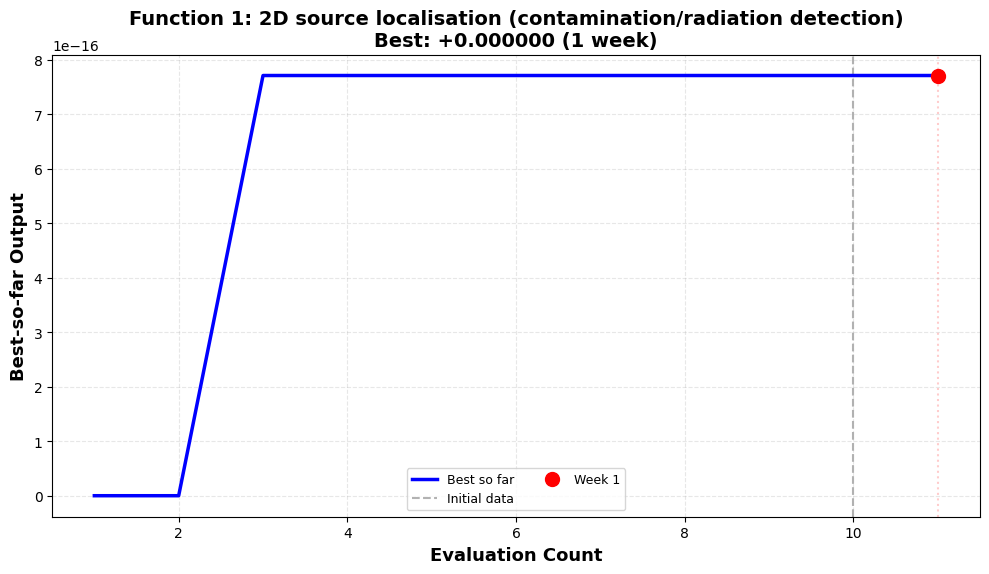

  ✓ Saved: function_1_week01.png

Function 2: 2D noisy scoring system with local optima


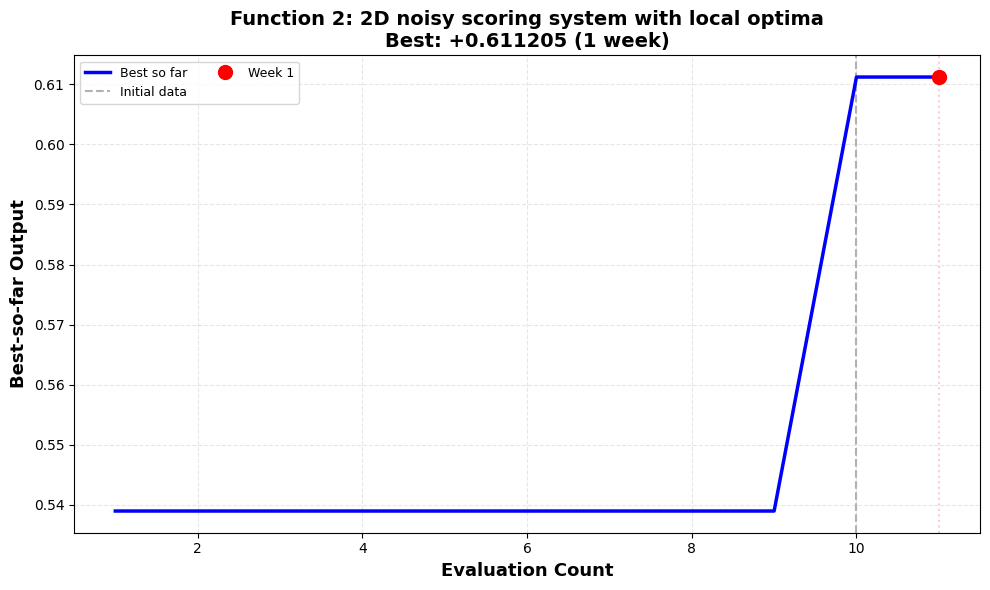

  ✓ Saved: function_2_week01.png

Function 3: 3D drug discovery mixture optimisation


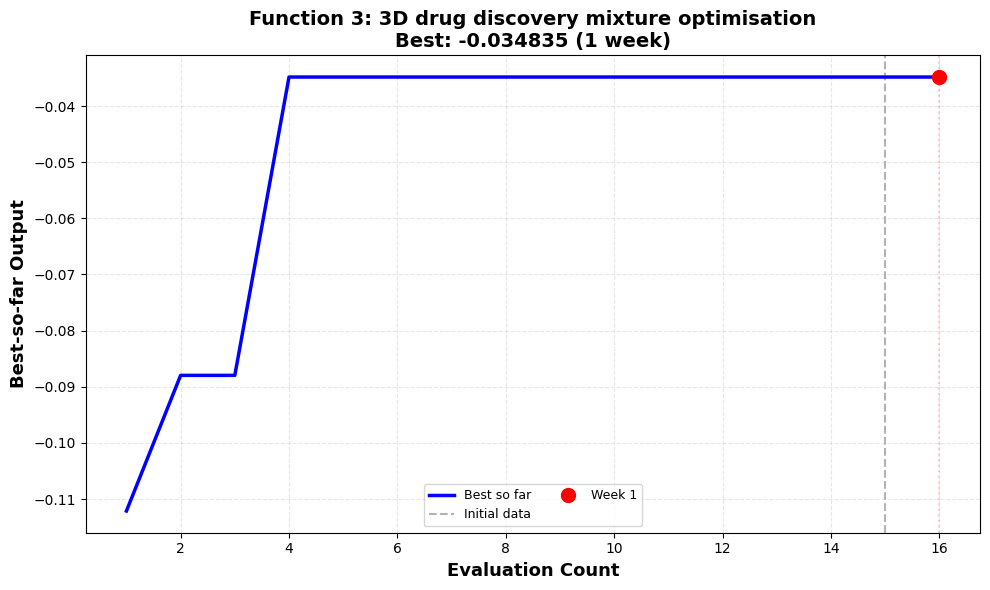

  ✓ Saved: function_3_week01.png

Function 4: 4D business configuration with costly evaluations


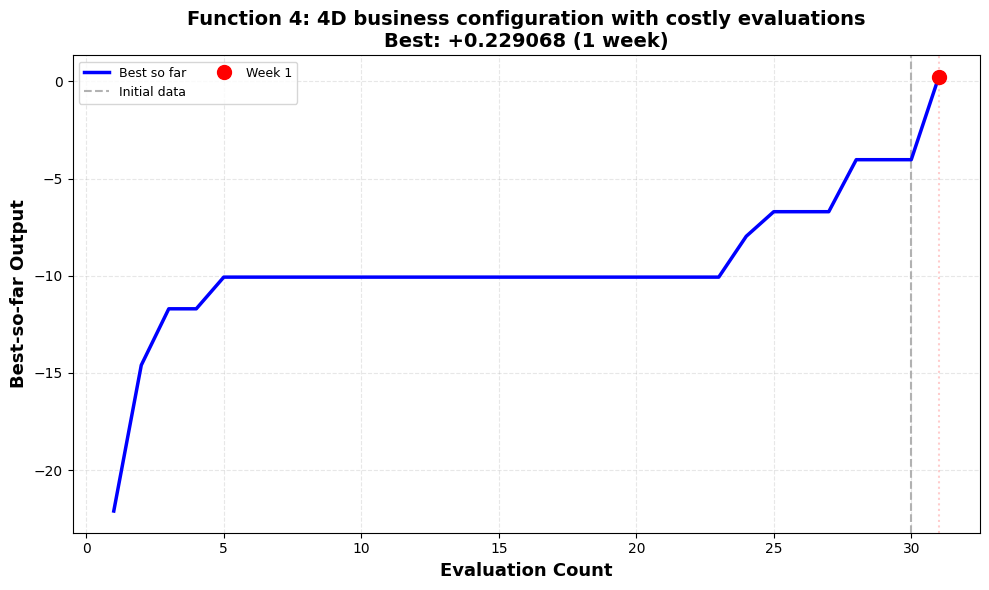

  ✓ Saved: function_4_week01.png

Function 5: 4D chemical process yield maximisation


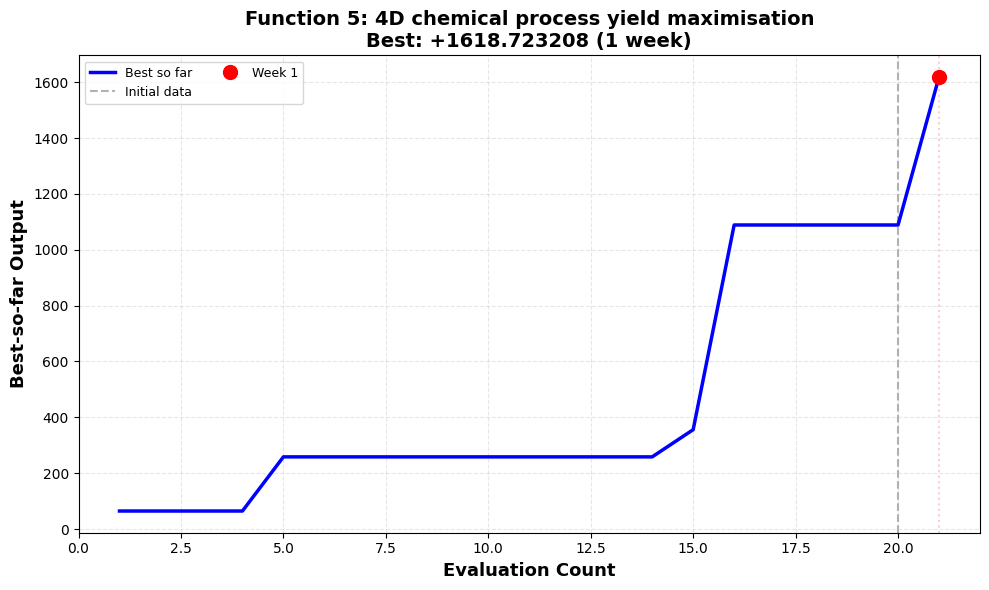

  ✓ Saved: function_5_week01.png

Function 6: 5D recipe-style optimisation


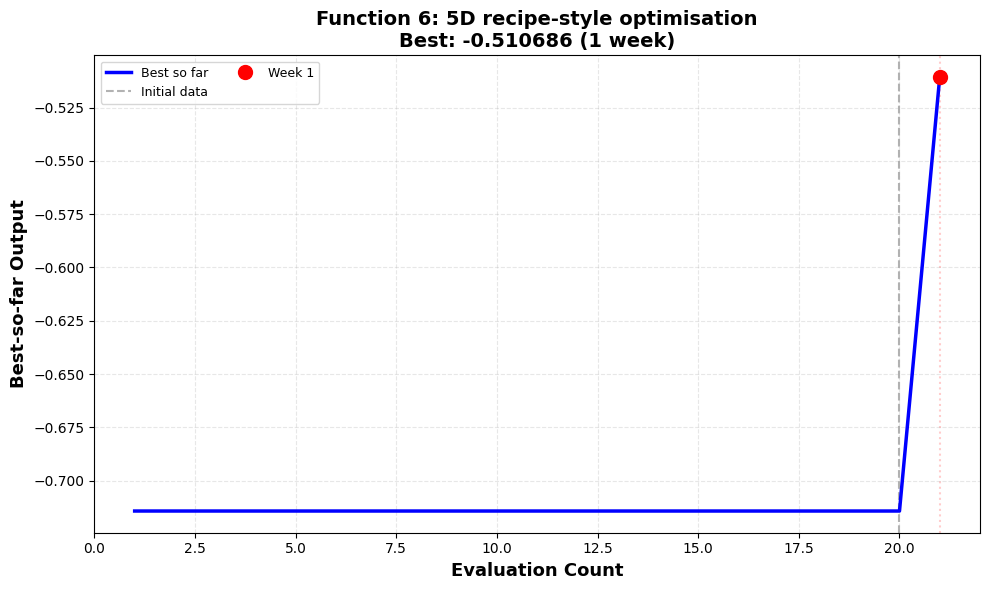

  ✓ Saved: function_6_week01.png

Function 7: 6D hyperparameter tuning


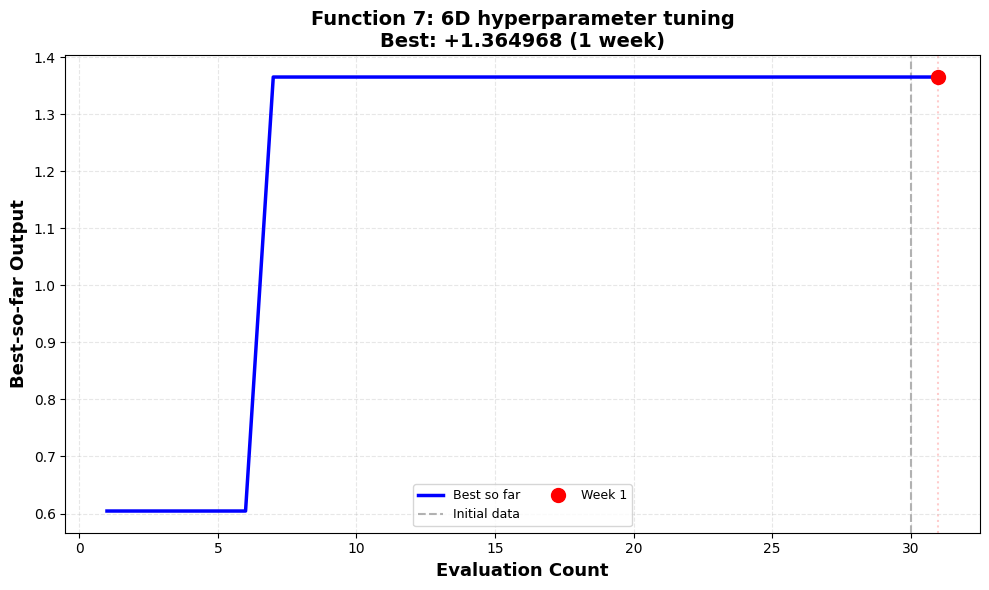

  ✓ Saved: function_7_week01.png

Function 8: 8D high-dimensional hyperparameter optimisation


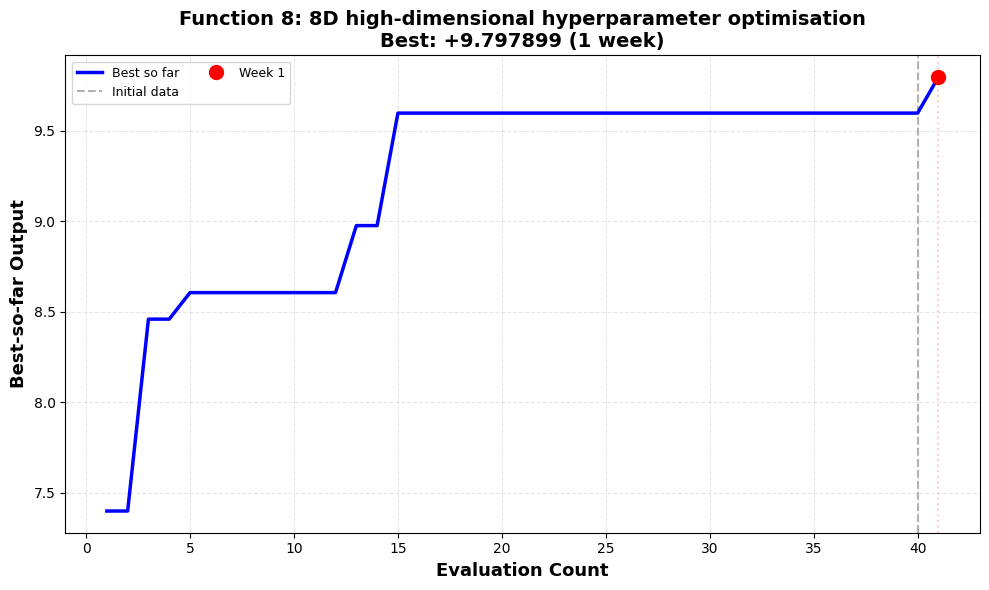

  ✓ Saved: function_8_week01.png

✓ All plots saved to: c:\Users\Diran\Coursework\CapStone00\plots\historical

[5/5] Saving outputs...
⚠️  Warning: Object of type bool_ is not JSON serializable

WORKFLOW COMPLETE ✓
Week 1 processed: 4/8 functions improved
Week 2 proposals ready

Next steps:
1. Submit proposals from: c:\Users\Diran\Coursework\CapStone00\submissions\week_02\inputs.txt
2. Save portal results to: c:\Users\Diran\Coursework\CapStone00\submissions\week_02\outputs.txt
3. Run again with week=2


In [12]:
# RUN THIS TO START THE WORKFLOW
result = run_intelligent_workflow()

## Cell 13: Utility Functions (Optional)

**Course note pointer:** Additional helpers for data analysis and debugging

In [13]:
"""
Utility Functions
"""

def show_current_state():
    """Display detailed current state"""
    print("\nCURRENT DATA STATE")
    print("="*70)
    state = get_current_data_state()
    for k, info in state.items():
        print(f"\nFunction {k} ({INITIAL_SIZES[k][1]}D): {FUNCTION_DESCRIPTIONS[k]}")
        print(f"  Total points: {info['total_points']} (initial: {info['initial_size']}, added: {info['weeks_added']})")
        print(f"  Best value: {info['best_value']:+.6f}")
        if info['latest_value'] is not None:
            print(f"  Latest value: {info['latest_value']:+.6f}")
    print("="*70)

def list_available_weeks():
    """List processed weeks"""
    weeks = sorted([d.name for d in SUBMISSIONS_DIR.glob("week_*") if d.is_dir()])
    print(f"\nProcessed weeks: {len(weeks)}")
    for w in weeks:
        wdir = SUBMISSIONS_DIR / w
        has_inputs = (wdir / "inputs.txt").exists() or len(list(wdir.glob("Week*.txt"))) > 0
        has_outputs = (wdir / "outputs.txt").exists()
        status = "✓" if has_inputs and has_outputs else "⚠"
        print(f"  {status} {w}")
    return weeks

def regenerate_plots(week_num=None, show_inline=True):
    """Regenerate all plots"""
    return generate_all_plots(week_num, show_inline)

# Uncomment to use:
# show_current_state()
# list_available_weeks()
# regenerate_plots()

print("✓ Utility functions loaded")

✓ Utility functions loaded
